This kernel shows how one can try to explain the predictions of a given boosted tree model using the lib SHAP https://github.com/slundberg/shap

The model is then retrained only with the best features to avoid fitting to noise and improve our LB score ;)

It is based on the best performing public script and some other variants: i.e. https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features et al.

In [2]:
# 初始化环境和导入依赖
import numpy as np
import pandas as pd
import shap
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 工具函数定义
class TimeTracker:
    def __init__(self, operation_name):
        self.operation_name = operation_name
        self.start_time = None
        
    def __enter__(self):
        self.start_time = time.time()
        return self
        
    def __exit__(self, *args):
        elapsed = time.time() - self.start_time
        print(f"[计时] {self.operation_name} - 耗时: {elapsed:.1f}秒")

def compute_geometric_mean(data_vector):
    positive_data = data_vector[data_vector > 0]
    if len(positive_data) == 0:
        return np.nan
    return np.exp(np.mean(np.log(positive_data)))

def categorical_to_dummy_variables(dataframe, handle_nan=True):
    original_columns = dataframe.columns.tolist()
    categorical_columns = [col for col in dataframe.columns if dataframe[col].dtype == 'object']
    processed_df = pd.get_dummies(dataframe, columns=categorical_columns, dummy_na=handle_nan)
    new_columns = [col for col in processed_df.columns if col not in original_columns]
    return processed_df, new_columns

In [3]:
def prepare_application_data(max_rows=None, encode_nan=True):
    # 读取训练和测试数据
    train_data = pd.read_csv('../input/application_train.csv', nrows=max_rows)
    test_data = pd.read_csv('../input/application_test.csv', nrows=max_rows)
    
    print(f"训练集样本数: {len(train_data)}, 测试集样本数: {len(test_data)}")
    
    # 合并数据集
    combined_data = pd.concat([train_data, test_data], ignore_index=True)
    
    # 清理异常数据
    combined_data = combined_data[combined_data['CODE_GENDER'] != 'XNA']
    
    # 识别文档和标志列
    document_flags = [col for col in combined_data.columns if 'FLAG_DOC' in col]
    binary_flags = [col for col in combined_data.columns if ('FLAG_' in col) and 
                   ('FLAG_DOC' not in col) and ('_FLAG_' not in col)]
    
    # 处理异常就业天数
    combined_data['DAYS_EMPLOYED'] = combined_data['DAYS_EMPLOYED'].replace(365243, np.nan)
    
    # 按组织类型计算收入中位数
    org_income_median = combined_data.groupby('ORGANIZATION_TYPE')['AMT_INCOME_TOTAL'].median()
    
    # 创建衍生特征 - 第一部分
    combined_data['CREDIT_ANNUITY_RATIO'] = combined_data['AMT_CREDIT'] / combined_data['AMT_ANNUITY']
    combined_data['CREDIT_GOODS_RATIO'] = combined_data['AMT_CREDIT'] / combined_data['AMT_GOODS_PRICE']
    combined_data['DOCUMENT_KURTOSIS'] = combined_data[document_flags].kurtosis(axis=1)
    combined_data['BINARY_FLAGS_SUM'] = combined_data[binary_flags].sum(axis=1)
    combined_data['INCOME_PER_CHILD'] = combined_data['AMT_INCOME_TOTAL'] / (1 + combined_data['CNT_CHILDREN'])
    combined_data['INCOME_BY_ORG_TYPE'] = combined_data['ORGANIZATION_TYPE'].map(org_income_median)
    
    # 创建衍生特征 - 第二部分
    combined_data['EMPLOYMENT_AGE_RATIO'] = combined_data['DAYS_EMPLOYED'] / combined_data['DAYS_BIRTH']
    combined_data['EMPLOYMENT_ADULT_RATIO'] = combined_data['DAYS_EMPLOYED'] / (combined_data['DAYS_BIRTH'] + 18*365)
    combined_data['AGE_EMPLOYMENT_RATIO'] = combined_data['DAYS_BIRTH'] / (1 + combined_data['DAYS_EMPLOYED'])
    combined_data['INCOME_ANNUITY_RATIO'] = combined_data['AMT_INCOME_TOTAL'] / (1 + combined_data['AMT_ANNUITY'])
    combined_data['ANNUITY_INCOME_RATIO'] = combined_data['AMT_ANNUITY'] / (1 + combined_data['AMT_INCOME_TOTAL'])
    
    # 外部数据源特征处理
    ext_sources = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
    combined_data['EXT_SOURCES_MEDIAN'] = combined_data[ext_sources].median(axis=1, skipna=True)
    combined_data['EXT_SOURCES_AVG'] = combined_data[ext_sources].mean(axis=1, skipna=True)
    combined_data['EXT_SOURCES_PRODUCT'] = combined_data[ext_sources].prod(axis=1, skipna=True, min_count=1)
    combined_data['EXT_SOURCES_MAX'] = combined_data[ext_sources].max(axis=1, skipna=True)
    combined_data['EXT_SOURCES_MIN'] = combined_data[ext_sources].min(axis=1, skipna=True)
    combined_data['EXT_SOURCES_STD'] = combined_data[ext_sources].std(axis=1, skipna=True)
    combined_data['EXT_SOURCES_MAD'] = combined_data[ext_sources].mad(axis=1, skipna=True)
    combined_data['EXT_SOURCES_GEOMEAN'] = combined_data[ext_sources].apply(compute_geometric_mean, axis=1)
    
    # 额外比率特征
    combined_data['EMPLOYMENT_PERCENTAGE'] = combined_data['DAYS_EMPLOYED'] / combined_data['DAYS_BIRTH']
    combined_data['INCOME_CREDIT_PERCENTAGE'] = combined_data['AMT_INCOME_TOTAL'] / combined_data['AMT_CREDIT']
    combined_data['INCOME_PER_FAMILY_MEMBER'] = combined_data['AMT_INCOME_TOTAL'] / combined_data['CNT_FAM_MEMBERS']
    combined_data['ANNUITY_INCOME_PERCENTAGE'] = combined_data['AMT_ANNUITY'] / combined_data['AMT_INCOME_TOTAL']
    combined_data['PAYMENT_TO_CREDIT_RATIO'] = combined_data['AMT_ANNUITY'] / combined_data['AMT_CREDIT']
    
    # 更多衍生特征
    combined_data['CAR_AGE_RATIO'] = combined_data['OWN_CAR_AGE'] / combined_data['DAYS_BIRTH']
    combined_data['CAR_EMPLOYMENT_RATIO'] = combined_data['OWN_CAR_AGE'] / combined_data['DAYS_EMPLOYED']
    combined_data['PHONE_CHANGE_AGE_RATIO'] = combined_data['DAYS_LAST_PHONE_CHANGE'] / combined_data['DAYS_BIRTH']
    combined_data['PHONE_CHANGE_EMPLOYMENT_RATIO'] = combined_data['DAYS_LAST_PHONE_CHANGE'] / combined_data['DAYS_EMPLOYED']
    combined_data['CREDIT_INCOME_RATIO'] = combined_data['AMT_CREDIT'] / combined_data['AMT_INCOME_TOTAL']
    
    # 分类变量编码
    binary_features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
    for feature in binary_features:
        combined_data[feature], _ = pd.factorize(combined_data[feature])
    
    # One-hot编码
    combined_data, encoded_columns = categorical_to_dummy_variables(combined_data, encode_nan)
    
    # 移除不重要的文档标志
    unimportant_docs = [f'FLAG_DOCUMENT_{i}' for i in [2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]]
    combined_data = combined_data.drop(columns=unimportant_docs, errors='ignore')
    
    del train_data, test_data
    gc.collect()
    
    return combined_data

In [4]:
def process_credit_bureau_data(max_rows=None, encode_nan=True):
    bureau_data = pd.read_csv('../input/bureau.csv', nrows=max_rows)
    bureau_balance = pd.read_csv('../input/bureau_balance.csv', nrows=max_rows)
    
    # 编码分类变量
    bureau_balance, bb_categorical = categorical_to_dummy_variables(bureau_balance, encode_nan)
    bureau_data, bureau_categorical = categorical_to_dummy_variables(bureau_data, encode_nan)
    
    # 征信余额数据聚合
    bb_agg_config = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_categorical:
        bb_agg_config[col] = ['mean']
    
    bb_aggregated = bureau_balance.groupby('SK_ID_BUREAU').agg(bb_agg_config)
    bb_aggregated.columns = [f"{col[0]}_{col[1].upper()}" for col in bb_aggregated.columns]
    
    # 合并征信数据
    bureau_data = bureau_data.merge(bb_aggregated, how='left', on='SK_ID_BUREAU')
    bureau_data = bureau_data.drop(columns=['SK_ID_BUREAU'])
    
    del bureau_balance, bb_aggregated
    gc.collect()
    
    # 数值型特征聚合配置
    numerical_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    
    # 分类特征聚合配置
    categorical_aggregations = {}
    for cat in bureau_categorical:
        categorical_aggregations[cat] = ['mean']
    for cat in bb_categorical:
        categorical_aggregations[f"{cat}_MEAN"] = ['mean']
    
    # 整体聚合
    all_aggregations = {**numerical_aggregations, **categorical_aggregations}
    bureau_aggregated = bureau_data.groupby('SK_ID_CURR').agg(all_aggregations)
    bureau_aggregated.columns = [f"BURO_{col[0]}_{col[1].upper()}" for col in bureau_aggregated.columns]
    
    # 活跃信用账户特征
    active_credits = bureau_data[bureau_data['CREDIT_ACTIVE_Active'] == 1]
    active_aggregated = active_credits.groupby('SK_ID_CURR').agg(numerical_aggregations)
    active_aggregated.columns = [f"ACTIVE_{col[0]}_{col[1].upper()}" for col in active_aggregated.columns]
    bureau_aggregated = bureau_aggregated.merge(active_aggregated, how='left', on='SK_ID_CURR')
    
    del active_credits, active_aggregated
    gc.collect()
    
    # 关闭信用账户特征
    closed_credits = bureau_data[bureau_data['CREDIT_ACTIVE_Closed'] == 1]
    closed_aggregated = closed_credits.groupby('SK_ID_CURR').agg(numerical_aggregations)
    closed_aggregated.columns = [f"CLOSED_{col[0]}_{col[1].upper()}" for col in closed_aggregated.columns]
    bureau_aggregated = bureau_aggregated.merge(closed_aggregated, how='left', on='SK_ID_CURR')
    
    # 处理其他信用状态
    credit_statuses = ['Sold', 'Bad debt']
    for status in credit_statuses:
        status_col = f'CREDIT_ACTIVE_{status}'
        if status_col in bureau_data.columns:
            status_data = bureau_data[bureau_data[status_col] == 1]
            status_aggregated = status_data.groupby('SK_ID_CURR').agg(numerical_aggregations)
            status_aggregated.columns = [f"{status.upper()}_{col[0]}_{col[1].upper()}" for col in status_aggregated.columns]
            bureau_aggregated = bureau_aggregated.merge(status_aggregated, how='left', on='SK_ID_CURR')
            del status_data, status_aggregated
            gc.collect()
    
    del closed_credits, closed_aggregated, bureau_data
    gc.collect()
    
    return bureau_aggregated

In [5]:
def process_previous_applications(max_rows=None, encode_nan=True):
    previous_apps = pd.read_csv('../input/previous_application.csv', nrows=max_rows)
    previous_apps, categorical_cols = categorical_to_dummy_variables(previous_apps, encode_nan)
    
    # 处理异常日期值
    date_columns = ['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 
                   'DAYS_LAST_DUE', 'DAYS_TERMINATION']
    for col in date_columns:
        previous_apps[col] = previous_apps[col].replace(365243, np.nan)
    
    # 创建申请信用比率
    previous_apps['APPLICATION_CREDIT_RATIO'] = previous_apps['AMT_APPLICATION'] / previous_apps['AMT_CREDIT']
    
    # 数值型特征聚合
    numerical_agg_config = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    
    # 分类特征聚合
    categorical_agg_config = {}
    for cat in categorical_cols:
        categorical_agg_config[cat] = ['mean']
    
    # 整体聚合
    all_agg_config = {**numerical_agg_config, **categorical_agg_config}
    prev_aggregated = previous_apps.groupby('SK_ID_CURR').agg(all_agg_config)
    prev_aggregated.columns = [f"PREV_{col[0]}_{col[1].upper()}" for col in prev_aggregated.columns]
    
    # 已批准申请特征
    approved_apps = previous_apps[previous_apps['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_aggregated = approved_apps.groupby('SK_ID_CURR').agg(numerical_agg_config)
    approved_aggregated.columns = [f"APPROVED_{col[0]}_{col[1].upper()}" for col in approved_aggregated.columns]
    prev_aggregated = prev_aggregated.merge(approved_aggregated, how='left', on='SK_ID_CURR')
    
    # 被拒绝申请特征
    refused_apps = previous_apps[previous_apps['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_aggregated = refused_apps.groupby('SK_ID_CURR').agg(numerical_agg_config)
    refused_aggregated.columns = [f"REFUSED_{col[0]}_{col[1].upper()}" for col in refused_aggregated.columns]
    prev_aggregated = prev_aggregated.merge(refused_aggregated, how='left', on='SK_ID_CURR')
    
    # 其他申请状态
    application_statuses = ['Canceled', 'Unused offer']
    for status in application_statuses:
        status_col = f'NAME_CONTRACT_STATUS_{status}'
        if status_col in previous_apps.columns:
            status_data = previous_apps[previous_apps[status_col] == 1]
            status_aggregated = status_data.groupby('SK_ID_CURR').agg(numerical_agg_config)
            status_aggregated.columns = [f"{status.upper()}_{col[0]}_{col[1].upper()}" for col in status_aggregated.columns]
            prev_aggregated = prev_aggregated.merge(status_aggregated, how='left', on='SK_ID_CURR')
            del status_data, status_aggregated
            gc.collect()
    
    del refused_apps, refused_aggregated, approved_apps, approved_aggregated, previous_apps
    gc.collect()
    
    return prev_aggregated

def process_pos_cash_data(max_rows=None, encode_nan=True):
    pos_data = pd.read_csv('../input/POS_CASH_balance.csv', nrows=max_rows)
    pos_data, categorical_cols = categorical_to_dummy_variables(pos_data, encode_nan)
    
    # 聚合配置
    aggregation_config = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean', 'sum'],
        'SK_DPD_DEF': ['max', 'mean', 'sum']
    }
    
    for cat in categorical_cols:
        aggregation_config[cat] = ['mean']
    
    pos_aggregated = pos_data.groupby('SK_ID_CURR').agg(aggregation_config)
    pos_aggregated.columns = [f"POS_{col[0]}_{col[1].upper()}" for col in pos_aggregated.columns]
    
    # 计数特征
    pos_aggregated['POS_ACCOUNT_COUNT'] = pos_data.groupby('SK_ID_CURR').size()
    
    del pos_data
    gc.collect()
    
    return pos_aggregated

def process_installment_data(max_rows=None, encode_nan=True):
    installment_data = pd.read_csv('../input/installments_payments.csv', nrows=max_rows)
    installment_data, categorical_cols = categorical_to_dummy_variables(installment_data, encode_nan)
    
    # 创建衍生特征
    installment_data['PAYMENT_PERCENTAGE'] = installment_data['AMT_PAYMENT'] / installment_data['AMT_INSTALMENT']
    installment_data['PAYMENT_DIFFERENCE'] = installment_data['AMT_INSTALMENT'] - installment_data['AMT_PAYMENT']
    
    # 计算逾期天数
    installment_data['DAYS_PAST_DUE'] = installment_data['DAYS_ENTRY_PAYMENT'] - installment_data['DAYS_INSTALMENT']
    installment_data['DAYS_BEFORE_DUE'] = installment_data['DAYS_INSTALMENT'] - installment_data['DAYS_ENTRY_PAYMENT']
    installment_data['DAYS_PAST_DUE'] = installment_data['DAYS_PAST_DUE'].clip(lower=0)
    installment_data['DAYS_BEFORE_DUE'] = installment_data['DAYS_BEFORE_DUE'].clip(lower=0)
    
    # 聚合配置
    aggregation_config = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DAYS_PAST_DUE': ['max', 'mean', 'sum', 'var'],
        'DAYS_BEFORE_DUE': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_PERCENTAGE': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFFERENCE': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    
    for cat in categorical_cols:
        aggregation_config[cat] = ['mean']
    
    installment_aggregated = installment_data.groupby('SK_ID_CURR').agg(aggregation_config)
    installment_aggregated.columns = [f"INSTAL_{col[0]}_{col[1].upper()}" for col in installment_aggregated.columns]
    
    # 计数特征
    installment_aggregated['INSTAL_ACCOUNT_COUNT'] = installment_data.groupby('SK_ID_CURR').size()
    
    del installment_data
    gc.collect()
    
    return installment_aggregated

def process_credit_card_data(max_rows=None, encode_nan=True):
    cc_data = pd.read_csv('../input/credit_card_balance.csv', nrows=max_rows)
    cc_data, categorical_cols = categorical_to_dummy_variables(cc_data, encode_nan)
    
    # 移除不必要的列
    cc_data = cc_data.drop(columns=['SK_ID_PREV'])
    
    # 聚合配置
    aggregation_functions = ['min', 'max', 'mean', 'sum', 'var']
    cc_aggregated = cc_data.groupby('SK_ID_CURR').agg(aggregation_functions)
    cc_aggregated.columns = [f"CC_{col[0]}_{col[1].upper()}" for col in cc_aggregated.columns]
    
    # 计数特征
    cc_aggregated['CC_ACCOUNT_COUNT'] = cc_data.groupby('SK_ID_CURR').size()
    
    del cc_data
    gc.collect()
    
    return cc_aggregated

In [6]:
def train_lightgbm_model(training_data, training_labels, testing_data, n_splits=5, use_stratified=False, test_mode=False):
    print(f"开始LightGBM训练. 训练集: {training_data.shape}, 测试集: {testing_data.shape}")
    
    # 选择交叉验证策略
    if use_stratified:
        cv_strategy = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=47)
    else:
        cv_strategy = KFold(n_splits=n_splits, shuffle=True, random_state=47)
    
    # 初始化结果存储
    out_of_fold_predictions = np.zeros(training_data.shape[0])
    submission_predictions = np.zeros(testing_data.shape[0])
    feature_importance_data = pd.DataFrame()
    performance_scores = []
    trained_models = []
    
    for fold_num, (train_indices, valid_indices) in enumerate(cv_strategy.split(training_data, training_labels)):
        X_train, y_train = training_data.iloc[train_indices], training_labels.iloc[train_indices]
        X_valid, y_valid = training_data.iloc[valid_indices], training_labels.iloc[valid_indices]

        # 配置LightGBM参数
        lgb_model = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1,
        )

        # 训练模型
        lgb_model.fit(X_train, y_train, 
                     eval_set=[(X_train, y_train), (X_valid, y_valid)], 
                     eval_metric='auc', verbose=200, early_stopping_rounds=200)

        # 生成预测
        out_of_fold_predictions[valid_indices] = lgb_model.predict_proba(X_valid, num_iteration=lgb_model.best_iteration_)[:, 1]
        submission_predictions += lgb_model.predict_proba(testing_data, num_iteration=lgb_model.best_iteration_)[:, 1] / n_splits

        # 计算特征重要性
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = testing_data.columns.values
        fold_importance["importance"] = lgb_model.feature_importances_
        
        # 计算SHAP值
        explainer = shap.TreeExplainer(lgb_model)
        shap_values = explainer.shap_values(X_valid)
        if isinstance(shap_values, list):
            shap_values = shap_values[1]
        
        fold_importance["shap_importance"] = np.abs(shap_values).mean(axis=0)
        fold_importance["fold"] = fold_num + 1
        feature_importance_data = pd.concat([feature_importance_data, fold_importance], axis=0)
        
        # 记录性能
        fold_score = roc_auc_score(y_valid, out_of_fold_predictions[valid_indices])
        performance_scores.append(fold_score)
        print(f'Fold {fold_num + 1:2d} AUC: {fold_score:.6f}')
        
        trained_models.append(lgb_model)
        del lgb_model, X_train, y_train, X_valid, y_valid, fold_importance, explainer, shap_values
        gc.collect()

    # 计算总体性能
    overall_score = roc_auc_score(training_labels, out_of_fold_predictions)
    average_score = np.mean(performance_scores)
    print(f'整体AUC分数: {overall_score:.6f}')
    print(f'平均AUC分数: {average_score:.6f}')
    
    # 保存结果
    if not test_mode:
        pd.DataFrame(out_of_fold_predictions).to_csv(
            f"lightgbm_{testing_data.shape[1]:03d}_{overall_score:.5f}_oof.csv", index=False)
        
        submission_template = pd.read_csv('../input/sample_submission.csv')
        submission_template['TARGET'] = submission_predictions
        submission_template.to_csv(
            f"lightgbm_{testing_data.shape[1]:03d}_{overall_score:.5f}.csv", index=False)
    
    # 可视化结果
    visualize_feature_importance(feature_importance_data)
    visualize_shap_importance(feature_importance_data)
    
    return feature_importance_data, trained_models, performance_scores, out_of_fold_predictions, submission_predictions

def visualize_feature_importance(importance_data):
    top_features = importance_data[["feature", "importance"]].groupby("feature")["importance"]\
        .agg(['mean', 'std']).sort_values(by="mean", ascending=False).head(40).reset_index()
    top_features.columns = ["feature", "平均重要性", "标准差"]
    
    plt.figure(figsize=(8, 10))
    sns.barplot(x="平均重要性", y="feature", xerr=top_features['标准差'], data=top_features)
    plt.title('LightGBM 特征重要性 (交叉验证平均)')
    plt.tight_layout()
    plt.savefig('feature_importance_plot.png')
    plt.show()

def visualize_shap_importance(importance_data):
    top_shap_features = importance_data[["feature", "shap_importance"]].groupby("feature")["shap_importance"]\
        .agg(['mean', 'std']).sort_values(by="mean", ascending=False).head(40).reset_index()
    top_shap_features.columns = ["feature", "平均SHAP值", "标准差"]
    
    plt.figure(figsize=(8, 10))
    sns.barplot(x="平均SHAP值", y="feature", xerr=top_shap_features['标准差'], data=top_shap_features)
    plt.title('LightGBM SHAP值重要性 (交叉验证平均)')
    plt.tight_layout()
    plt.savefig('shap_importance_plot.png')
    plt.show()

def select_features_by_shap(importance_data, top_percentile=0.15):
    feature_shap_scores = importance_data[["feature", "shap_importance"]].groupby("feature")["shap_importance"]\
        .agg(['mean']).sort_values(by="mean", ascending=False).reset_index()
    
    n_top_features = int(feature_shap_scores.shape[0] * top_percentile)
    selected_features = feature_shap_scores[:n_top_features]["feature"].values
    
    print(f"## 选择前{top_percentile*100:.0f}%的特征，共 {len(selected_features)} 个:")
    print(selected_features)
    
    return selected_features

训练集样本数: 307511, 测试集样本数: 48744
[计时] 准备申请数据 - 耗时: 182.0秒
征信特征维度: (305811, 170)
[计时] 处理征信局数据 - 耗时: 52.8秒
历史申请特征维度: (338857, 309)
[计时] 处理历史申请数据 - 耗时: 69.0秒
POS现金特征维度: (337252, 20)
[计时] 处理POS现金数据 - 耗时: 23.7秒
分期付款特征维度: (339587, 28)
[计时] 处理分期付款数据 - 耗时: 54.6秒
信用卡特征维度: (103558, 141)
[计时] 处理信用卡数据 - 耗时: 43.9秒
[计时] 保存合并数据 - 耗时: 722.4秒
训练特征: (307507, 931), 测试特征: (48744, 931)
[计时] 准备训练和测试数据 - 耗时: 19.0秒
开始LightGBM训练. 训练集: (307507, 931), 测试集: (48744, 931)
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.798856	valid_1's auc: 0.777499
[400]	training's auc: 0.82288	valid_1's auc: 0.787226
[600]	training's auc: 0.839332	valid_1's auc: 0.790627
[800]	training's auc: 0.852221	valid_1's auc: 0.792085
[1000]	training's auc: 0.863468	valid_1's auc: 0.792765
[1200]	training's auc: 0.873466	valid_1's auc: 0.793283
[1400]	training's auc: 0.882652	valid_1's auc: 0.793376
[1600]	training's auc: 0.891464	valid_1's auc: 0.793626
[1800]	training's auc: 0.899463	valid_1's auc: 0.7

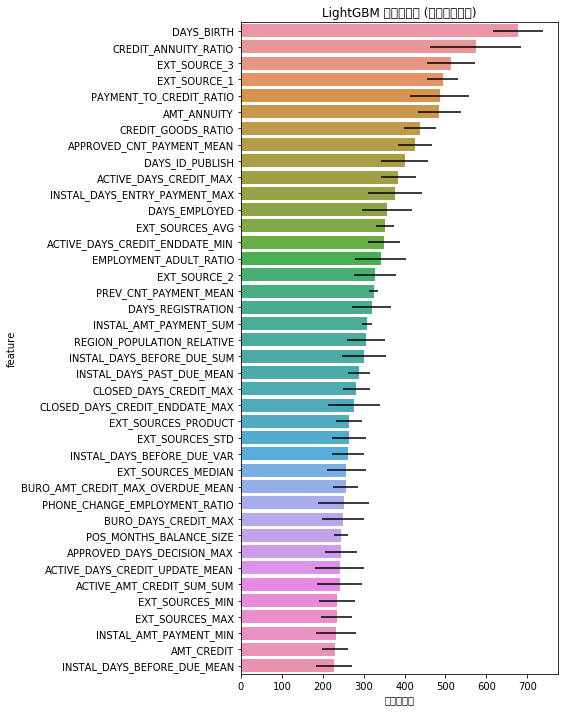

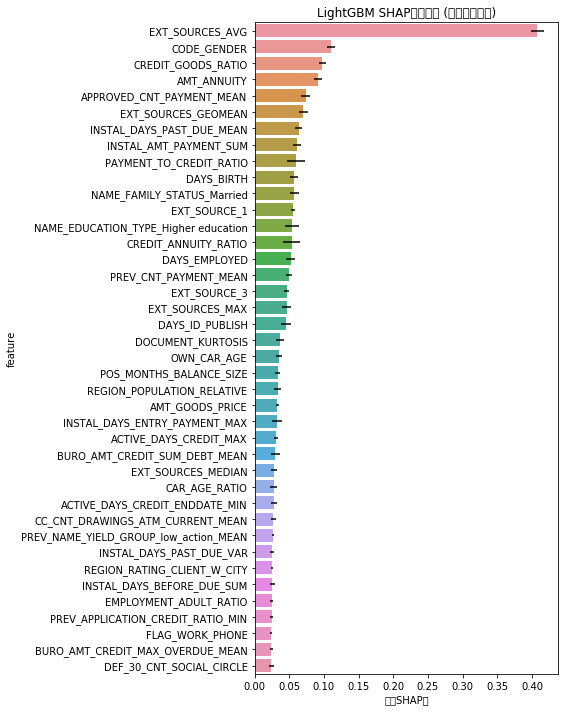

[计时] 第一阶段训练 - 全特征 - 耗时: 6619.5秒
## 选择前15%的特征，共 139 个:
['EXT_SOURCES_AVG' 'CODE_GENDER' 'CREDIT_GOODS_RATIO' 'AMT_ANNUITY'
 'APPROVED_CNT_PAYMENT_MEAN' 'EXT_SOURCES_GEOMEAN'
 'INSTAL_DAYS_PAST_DUE_MEAN' 'INSTAL_AMT_PAYMENT_SUM'
 'PAYMENT_TO_CREDIT_RATIO' 'DAYS_BIRTH' 'NAME_FAMILY_STATUS_Married'
 'EXT_SOURCE_1' 'NAME_EDUCATION_TYPE_Higher education'
 'CREDIT_ANNUITY_RATIO' 'DAYS_EMPLOYED' 'PREV_CNT_PAYMENT_MEAN'
 'EXT_SOURCE_3' 'EXT_SOURCES_MAX' 'DAYS_ID_PUBLISH' 'DOCUMENT_KURTOSIS'
 'OWN_CAR_AGE' 'POS_MONTHS_BALANCE_SIZE' 'REGION_POPULATION_RELATIVE'
 'AMT_GOODS_PRICE' 'INSTAL_DAYS_ENTRY_PAYMENT_MAX'
 'ACTIVE_DAYS_CREDIT_MAX' 'BURO_AMT_CREDIT_SUM_DEBT_MEAN'
 'EXT_SOURCES_MEDIAN' 'CAR_AGE_RATIO' 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN'
 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN'
 'PREV_NAME_YIELD_GROUP_low_action_MEAN' 'INSTAL_DAYS_PAST_DUE_VAR'
 'REGION_RATING_CLIENT_W_CITY' 'INSTAL_DAYS_BEFORE_DUE_SUM'
 'EMPLOYMENT_ADULT_RATIO' 'PREV_APPLICATION_CREDIT_RATIO_MIN'
 'FLAG_WORK_PHONE' 'BURO_AMT_CREDIT_M

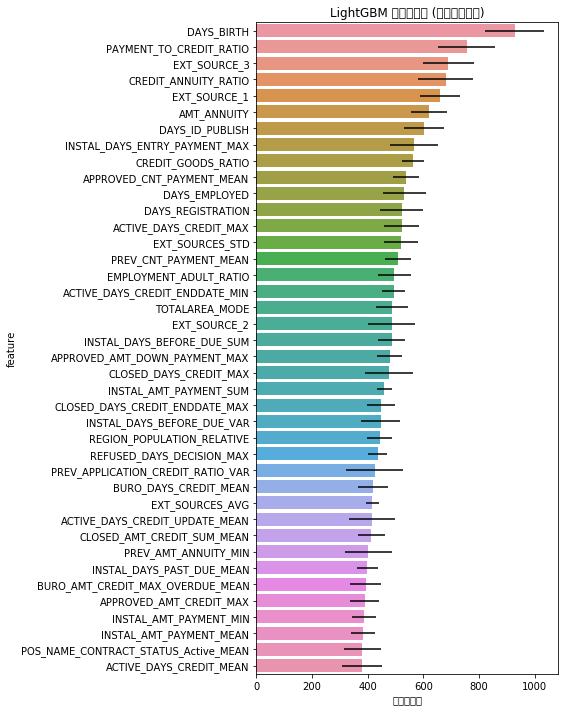

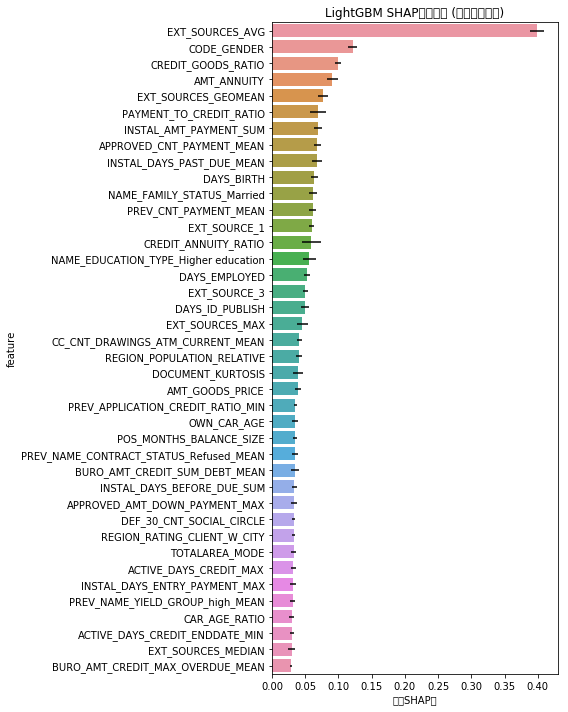

[计时] 第二阶段训练 - 精选特征 - 耗时: 3357.7秒
[计时] 完整机器学习流程 - 耗时: 11145.2秒


In [7]:
def execute_pipeline(debug_mode=False):
    max_rows = 10000 if debug_mode else None
    
    with TimeTracker("准备申请数据"):
        application_data = prepare_application_data(max_rows)
    
    with TimeTracker("处理征信局数据"):
        bureau_features = process_credit_bureau_data(max_rows)
        print(f"征信特征维度: {bureau_features.shape}")
        application_data = application_data.merge(bureau_features, how='left', on='SK_ID_CURR')
        del bureau_features
        gc.collect()
    
    with TimeTracker("处理历史申请数据"):
        previous_app_features = process_previous_applications(max_rows)
        print(f"历史申请特征维度: {previous_app_features.shape}")
        application_data = application_data.merge(previous_app_features, how='left', on='SK_ID_CURR')
        del previous_app_features
        gc.collect()
    
    with TimeTracker("处理POS现金数据"):
        pos_features = process_pos_cash_data(max_rows)
        print(f"POS现金特征维度: {pos_features.shape}")
        application_data = application_data.merge(pos_features, how='left', on='SK_ID_CURR')
        del pos_features
        gc.collect()
    
    with TimeTracker("处理分期付款数据"):
        installment_features = process_installment_data(max_rows)
        print(f"分期付款特征维度: {installment_features.shape}")
        application_data = application_data.merge(installment_features, how='left', on='SK_ID_CURR')
        del installment_features
        gc.collect()
    
    with TimeTracker("处理信用卡数据"):
        credit_card_features = process_credit_card_data(max_rows)
        print(f"信用卡特征维度: {credit_card_features.shape}")
        application_data = application_data.merge(credit_card_features, how='left', on='SK_ID_CURR')
        del credit_card_features
        gc.collect()
    
    with TimeTracker("保存合并数据"):
        application_data.to_csv('combined_dataset.csv.gz', compression='gzip', index=False)
    
    with TimeTracker("准备训练和测试数据"):
        feature_columns = [col for col in application_data.columns if col not in 
                         ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
        
        train_data = application_data[application_data['TARGET'].notnull()][feature_columns]
        train_labels = application_data[application_data['TARGET'].notnull()]['TARGET']
        test_data = application_data[application_data['TARGET'].isnull()][feature_columns]
        
        print(f"训练特征: {train_data.shape}, 测试特征: {test_data.shape}")
        del application_data
        gc.collect()
    
    # 第一阶段：使用所有特征训练
    with TimeTracker("第一阶段训练 - 全特征"):
        full_feature_importance, full_models, full_scores, full_oof, full_sub = train_lightgbm_model(
            train_data, train_labels, test_data, n_splits=5, use_stratified=False, test_mode=debug_mode)
    
    # 第二阶段：特征选择后训练
    with TimeTracker("第二阶段训练 - 精选特征"):
        best_features = select_features_by_shap(full_feature_importance, top_percentile=0.15)
        train_data_selected = train_data[best_features]
        test_data_selected = test_data[best_features]
        
        selected_feature_importance, selected_models, selected_scores, selected_oof, selected_sub = train_lightgbm_model(
            train_data_selected, train_labels, test_data_selected, n_splits=5, use_stratified=False, test_mode=debug_mode)
    
    return selected_feature_importance, selected_models, selected_scores

# 执行完整流程
if __name__ == "__main__":
    with TimeTracker("完整机器学习流程"):
        final_importance, final_models, final_scores = execute_pipeline(debug_mode=False)